In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from utils.dataloader import bin_avg, retrieve_data, dataloader, \
      drop_settlement_dup, load_data, frame_to_numpy, create_rolling_window_dataset
import os
from cycler import cycler

In [3]:
folder_path = "results/validation_short_ttm/ivrmse/"  # change this to your folder path
target_substring = "_convLSTMNEW"  # the substring to look for
option = 'call'
step = "h_1"

lowest_value = float('inf')
lowest_file_short = None

for file_name in os.listdir(folder_path):
    if file_name.endswith('.npy') and target_substring in file_name and option in file_name and step in file_name:
        file_path = os.path.join(folder_path, file_name)
        try:
            value = np.load(file_path)
            # If the file contains a single number
        
            if value < lowest_value:
                lowest_value = value
                lowest_file_short = file_name

        except Exception as e:
            print(f"Error loading {file_name}: {e}")

print(f"Lowest value: {lowest_value}")
print(f"From file: {lowest_file_short}")


Lowest value: 0.1297955229814273
From file: call_smooth_True_ws_63_h_1_2_7_4_convLSTMNEW.npy


In [4]:
folder_path = "results/validation_long_ttm/ivrmse/"  # change this to your folder path

lowest_value = float('inf')
lowest_file_long = None
smooth = 'smooth_True'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.npy') and target_substring in file_name and smooth in file_name and option in file_name and step in file_name:
        file_path = os.path.join(folder_path, file_name)
        try:
            value = np.load(file_path)
            # If the file contains a single number
        
            if value < lowest_value:
                lowest_value = value
                lowest_file_long = file_name

        except Exception as e:
            print(f"Error loading {file_name}: {e}")

print(f"Lowest value: {lowest_value}")
print(f"From file: {lowest_file_long}")

Lowest value: 0.06415787969520591
From file: call_smooth_True_ws_5_h_1_3_7_4_convLSTMNEW.npy


In [5]:
_, _, smooth_sh, _, ws_short, _, h_short, num_layers_short, k_height_short, k_width_short, _ = lowest_file_short.split("_")
_, _, smooth_long, _, ws_long, _, h_long, num_layers_long, k_height_long, k_width_long, _ = lowest_file_long.split("_")

In [6]:
tune_result_short =f'results/train_loss_short_ttm_{option}_sm_{smooth_sh}_ws_{ws_short}_h_{h_short}_{num_layers_short}_{k_height_short}_{k_width_short}{target_substring}.npy'
val_result_short =f'results/val_loss_short_ttm_{option}_sm_{smooth_sh}_ws_{ws_short}_h_{h_short}_{num_layers_short}_{k_height_short}_{k_width_short}{target_substring}.npy'

tune_result_long =f'results/train_loss_long_ttm_{option}_sm_{smooth_long}_ws_{ws_long}_h_{h_long}_{num_layers_long}_{k_height_long}_{k_width_long}{target_substring}.npy'
val_result_long =f'results/val_loss_long_ttm_{option}_sm_{smooth_long}_ws_{ws_long}_h_{h_long}_{num_layers_long}_{k_height_long}_{k_width_long}{target_substring}.npy'


In [7]:
train_loss_short = np.load(tune_result_short)
val_loss_short = np.load(val_result_short)

train_loss_long = np.load(tune_result_long)
val_loss_long = np.load(val_result_long)

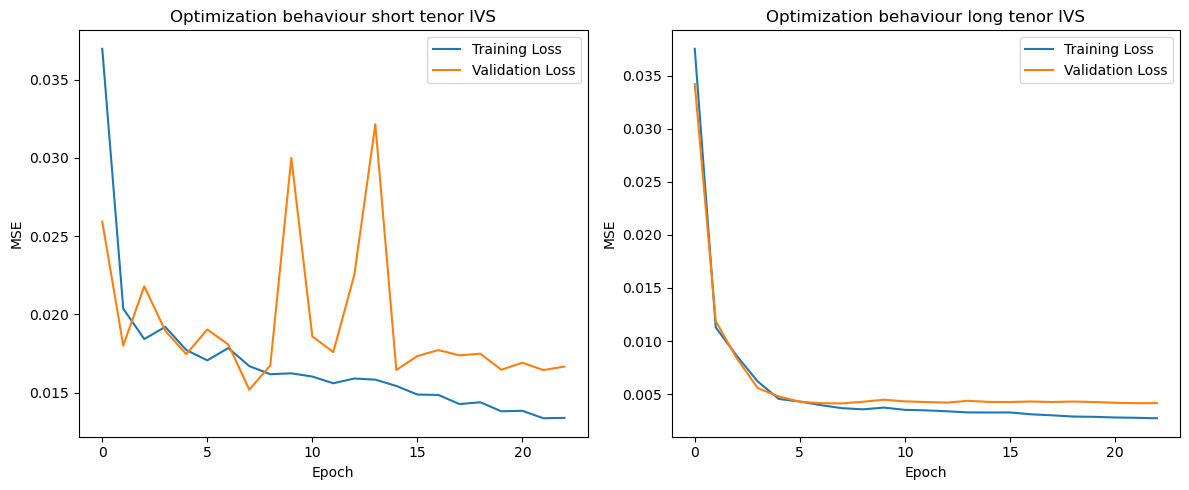

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

# Plot for short tenor IVS
axs[0].plot(train_loss_short, label='Training Loss')
axs[0].plot(val_loss_short, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')
axs[0].set_title('Optimization behaviour short tenor IVS')
axs[0].legend()

# Plot for long tenor IVS
axs[1].plot(train_loss_long, label='Training Loss')
axs[1].plot(val_loss_long, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE')
axs[1].set_title('Optimization behaviour long tenor IVS')
axs[1].legend()

# Save and show
plt.tight_layout()
plt.savefig('figures/ttm_epoch_side_by_side.png')
plt.show()

In [9]:
result_short = f"{option}_smooth_{smooth_sh}_ws_{ws_short}_h_{h_short}_{num_layers_short}_{k_height_short}_{k_width_short}{target_substring}.npy"
result_long = f"{option}_smooth_{smooth_long}_ws_{ws_long}_h_{h_long}_{num_layers_long}_{k_height_long}_{k_width_long}{target_substring}.npy"

In [10]:
# Lets make the graph that depicts IVRMSe and Roos for long vs short term maturity
ivrmse_long = np.load('results/test_long_ttm/ivrmse/' + result_long)
ivrmse_short = np.load('results/test_short_ttm/ivrmse/' + result_short)
ivrmse_h_long = np.load('results/test_long_ttm/ivrmse_h/' + result_long)
ivrmse_h_short = np.load('results/test_short_ttm/ivrmse_h/' + result_short)
roos_long = np.load('results/test_long_ttm/r_oos/' + result_long)
roos_short = np.load('results/test_short_ttm/r_oos/' + result_short)
roos_h_long = np.load('results/test_long_ttm/r_oos_h/' + result_long)
roos_h_short = np.load('results/test_short_ttm/r_oos_h/' +result_short)

surface_long = np.load('results/test_long_ttm/surface/' + result_long)
surface_short = np.load('results/test_short_ttm/surface/' + result_short)
surface_pred_long = np.load('results/test_long_ttm/surface_pred/' + result_long)
surface_pred_short = np.load('results/test_short_ttm/surface_pred/' + result_short)

df_test = pd.read_csv('data/final/evaluation/test_set.csv')
df = df_test.drop_duplicates(subset='date', keep='last')
T = ivrmse_h_short.shape[0]
dates = df['date'].iloc[-T:].reset_index(drop=True)

In [11]:
def calculate_r_oos_mask_test(y_true, y_pred,  all_points=False):
    mask = tf.cast(y_true > 0, tf.double)
    
    numerator = tf.reduce_sum(y_true * mask)  
    denominator = tf.reduce_sum(mask )      
    mean_IV = numerator / denominator  

    if not all_points:
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred) * mask)
        ss_tot = tf.reduce_sum(tf.square(y_true - mean_IV) * mask)
        r2 = 1 - ss_res / ss_tot
    else:
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred) * mask, axis=[1, 2])
        ss_tot = tf.reduce_sum(tf.square(y_true - mean_IV) * mask, axis=[1, 2])
        r2 = 1 - ss_res / ss_tot

    return r2.numpy()

In [12]:
long = calculate_r_oos_mask_test(surface_long, surface_pred_long)
short = calculate_r_oos_mask_test(surface_short, surface_pred_short)
print(long,short)

0.231536722108455 0.7071505335195343


In [13]:
long = calculate_r_oos_mask_test(surface_long, surface_pred_long, all_points=True)
short = calculate_r_oos_mask_test(surface_short, surface_pred_short, all_points=True)

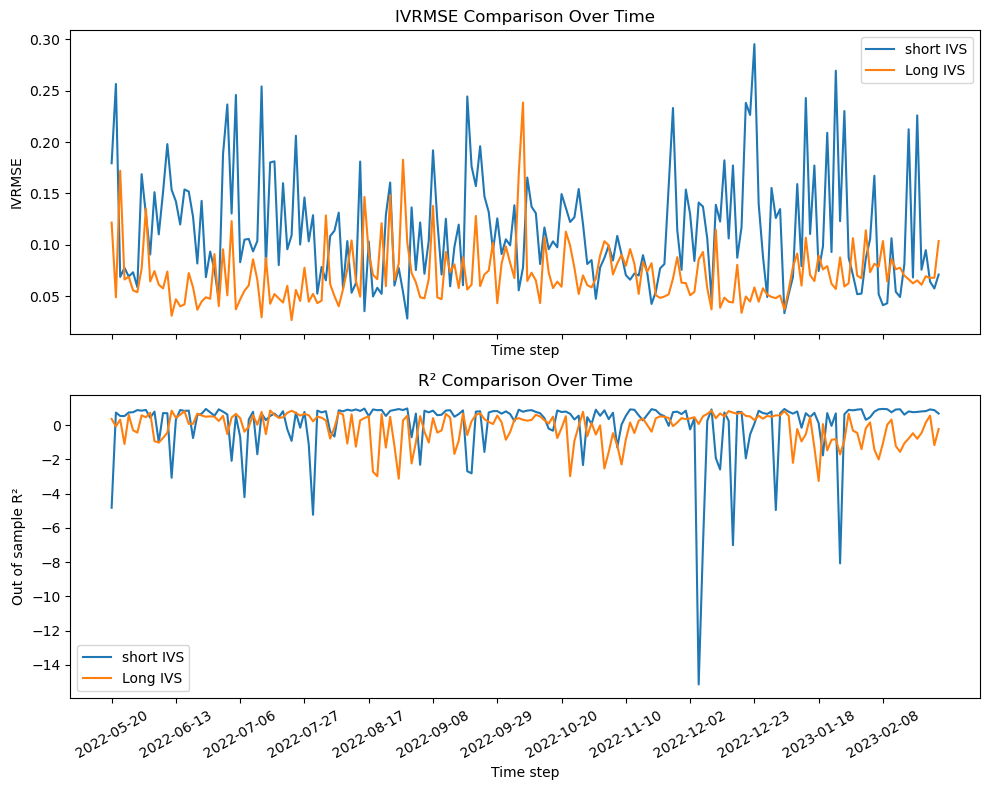

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)  # sharex aligns the x-axis

axs[0].plot(dates, ivrmse_h_short, label="short IVS")
ivrmse_h_long = ivrmse_h_long[-ivrmse_h_short.shape[0]:]
axs[0].plot(dates, ivrmse_h_long, label="Long IVS")
axs[0].set_xlabel("Time step")
axs[0].set_xticks(ticks=range(0, len(dates), 15), labels=dates[::15], rotation=30)
axs[0].set_ylabel("IVRMSE")
axs[0].set_title("IVRMSE Comparison Over Time")
axs[0].legend()

axs[1].plot(dates, short, label="short IVS")
long = long[-short.shape[0]:]
axs[1].plot(dates, long, label="Long IVS")
axs[1].set_xlabel("Time step")
axs[1].set_xticks(ticks=range(0, len(dates), 15), labels=dates[::15], rotation=30)
axs[1].set_ylabel("Out of sample R\u00b2")
axs[1].set_title("R\u00b2 Comparison Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()

In [15]:
print(ivrmse_long, ivrmse_short)

0.08349107621822124 0.1346177817368392


In [16]:
print(result_short)
print(result_long)

call_smooth_True_ws_63_h_1_2_7_4_convLSTMNEW.npy
call_smooth_True_ws_5_h_1_3_7_4_convLSTMNEW.npy


In [17]:
print("Short IVS hyperparameters:")
print(f"window: {ws_short} h: {h_short} layers: {num_layers_short} kernel height: {k_height_short} width: {k_width_short}")

Short IVS hyperparameters:
window: 63 h: 1 layers: 2 kernel height: 7 width: 4


In [18]:
print("Long IVS hyperparameters:")
print(f"window: {ws_long} h: {h_long} layers: {num_layers_long} kernel height: {k_height_long} width: {k_width_long}")

Long IVS hyperparameters:
window: 5 h: 1 layers: 3 kernel height: 7 width: 4


In [19]:
# Here, we need to retrieve the results for long vs short IVS, for various window sizes


In [35]:
# folder_path = "results/validation_short_ttm/ivrmse/"  # change this to your folder path
target_substring = "_convLSTMNEW"  # the substring to look for
option = 'call'
step = "h_1"



def print_results(run, target_substring, option, step):
    folder_path = "results/validation_"+ run + "/ivrmse/"
    # print(folder_path)
    lowest_value = float('inf')
    lowest_file = None
    smooth = 'smooth_True'

    for file_name in os.listdir(folder_path):
        
        
        if file_name.endswith('.npy') and target_substring in file_name and smooth in file_name and option in file_name and step in file_name:
            file_path = os.path.join(folder_path, file_name)
            try:
                value = np.load(file_path)
                # If the file contains a single number
            
                if value < lowest_value:
                    lowest_value = value
                    lowest_file = file_name

            except Exception as e:
                print(f"Error loading {file_name}: {e}")

    # print(f"Lowest value: {lowest_value}")
    # print(f"From file: {lowest_file}")

    _, _, smooth, _, ws, _, h, num_layers, k_height, k_width, _ = lowest_file.split("_")
    result = f"{option}_smooth_{smooth}_ws_{ws}_h_{h}_{num_layers}_{k_height}_{k_width}{target_substring}.npy"

    ivrmse= np.load(f'results/test_{run}/ivrmse/' + result)
    ivrmse_h = np.load(f'results/test_{run}/ivrmse_h/' + result)
    roos = np.load(f'results/test_{run}/r_oos/' + result)
    roos_h = np.load(f'results/test_{run}/r_oos_h/' +result)
    surface = np.load(f'results/test_{run}/surface/' + result)
    surface_pred = np.load(f'results/test_{run}/surface_pred/' + result)

        
    print(f"h = {step} ahead prediction for {option} option:, ivs: {run}")
    print(f"IVRMSE: {ivrmse*100:.3f}, R_oos: {roos*100:.3f}")
    print(f"Corrected R-squared: {calculate_r_oos_mask_test(surface, surface_pred)*100:.2f}")

for opt in ["call", "put"]:
    for run in ["long_ttm"]:
        for step in ["h_21_"]:
    
    
            print_results(run, target_substring, opt, step)


h = h_21_ ahead prediction for call option:, ivs: long_ttm
IVRMSE: 10.734, R_oos: -36.980
Corrected R-squared: -36.98
h = h_21_ ahead prediction for put option:, ivs: long_ttm
IVRMSE: 12.183, R_oos: -23.351
Corrected R-squared: -23.35
